In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import tifffile as tiff
from glob import glob

from tensorflow.keras.utils import normalize
import os
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam

In [2]:
#Resizing images, if needed
SIZE_X = 128 
SIZE_Y = 128
n_classes=4 #Number of classes for segmentation
num_images = 700  #Total 1600 available

In [3]:
img_names = glob('/content/drive/MyDrive/Data/car_semantic_seg/dataA/dataA/CameraRGB/*.png')
img_names.sort()

img_names_subset = img_names[0:num_images]
images = [cv2.resize(cv2.imread(mask, 0), (SIZE_X, SIZE_Y)) for mask in img_names_subset]
img_dataset = np.array(images)
img_dataset = np.expand_dims(img_dataset, axis = 3)

In [4]:
mask_names = glob('/content/drive/MyDrive/Data/car_semantic_seg/dataA/dataA/CameraSeg/*.png')
mask_names.sort()

mask_names_subset = mask_names[0:num_images]
masks = [cv2.resize(cv2.imread(mask, 0), (SIZE_X, SIZE_Y)) for mask in mask_names_subset]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

In [5]:
print('image dataset shape is :' , img_dataset.shape)
print('masks dataset shape is :' , mask_dataset.shape)

image dataset shape is : (700, 128, 128, 1)
masks dataset shape is : (700, 128, 128, 1)


In [6]:
#Encode labels to 0, 1, 2, 3, ... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w, _ = mask_dataset.shape  
mask_dataset_reshaped = mask_dataset.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(mask_dataset_encoded)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3])

In [7]:
#Normalize images
img_dataset = img_dataset /255.  #Can also normalize or scale using MinMax scaler

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img_dataset, mask_dataset_encoded, test_size = 0.20, random_state = 42)

In [9]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

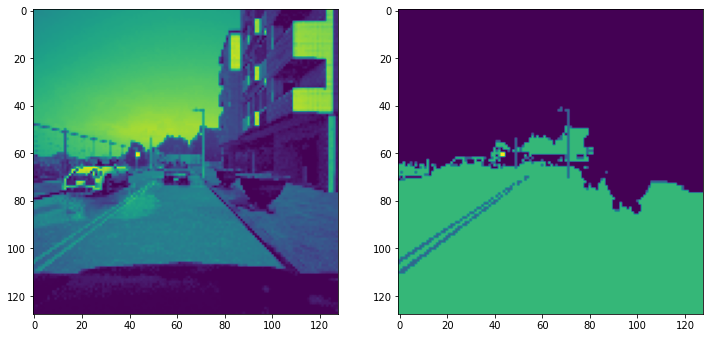

In [10]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0])
plt.subplot(122)
plt.imshow(y_train[image_number,:,:])
plt.show()

In [11]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [12]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [13]:
model = build_unet(input_shape, n_classes=4)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

softmax
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                     

In [14]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=40, 
                    validation_data=(X_test, y_test_cat), 
                    shuffle=False)

Epoch 1/40
70/70 [==============================] - 43s 489ms/step - loss: 0.4133 - accuracy: 0.8476 - val_loss: 1.2118 - val_accuracy: 0.7605
Epoch 2/40
70/70 [==============================] - 31s 445ms/step - loss: 0.2498 - accuracy: 0.9108 - val_loss: 0.9655 - val_accuracy: 0.8125
Epoch 3/40
70/70 [==============================] - 31s 445ms/step - loss: 0.2113 - accuracy: 0.9241 - val_loss: 0.9633 - val_accuracy: 0.7980
Epoch 4/40
70/70 [==============================] - 31s 445ms/step - loss: 0.1939 - accuracy: 0.9304 - val_loss: 0.9946 - val_accuracy: 0.7875
Epoch 5/40
70/70 [==============================] - 31s 445ms/step - loss: 0.1805 - accuracy: 0.9351 - val_loss: 0.9737 - val_accuracy: 0.7993
Epoch 6/40
70/70 [==============================] - 31s 445ms/step - loss: 0.1658 - accuracy: 0.9405 - val_loss: 0.6174 - val_accuracy: 0.8394
Epoch 7/40
70/70 [==============================] - 31s 445ms/step - loss: 0.1596 - accuracy: 0.9424 - val_loss: 0.3130 - val_accuracy: 0.8819

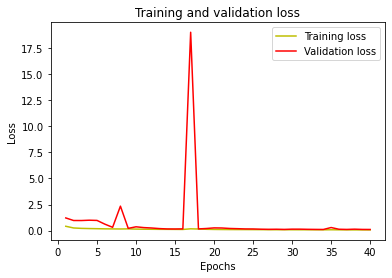

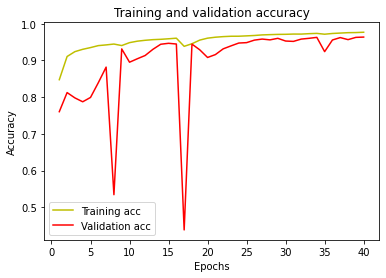

In [15]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

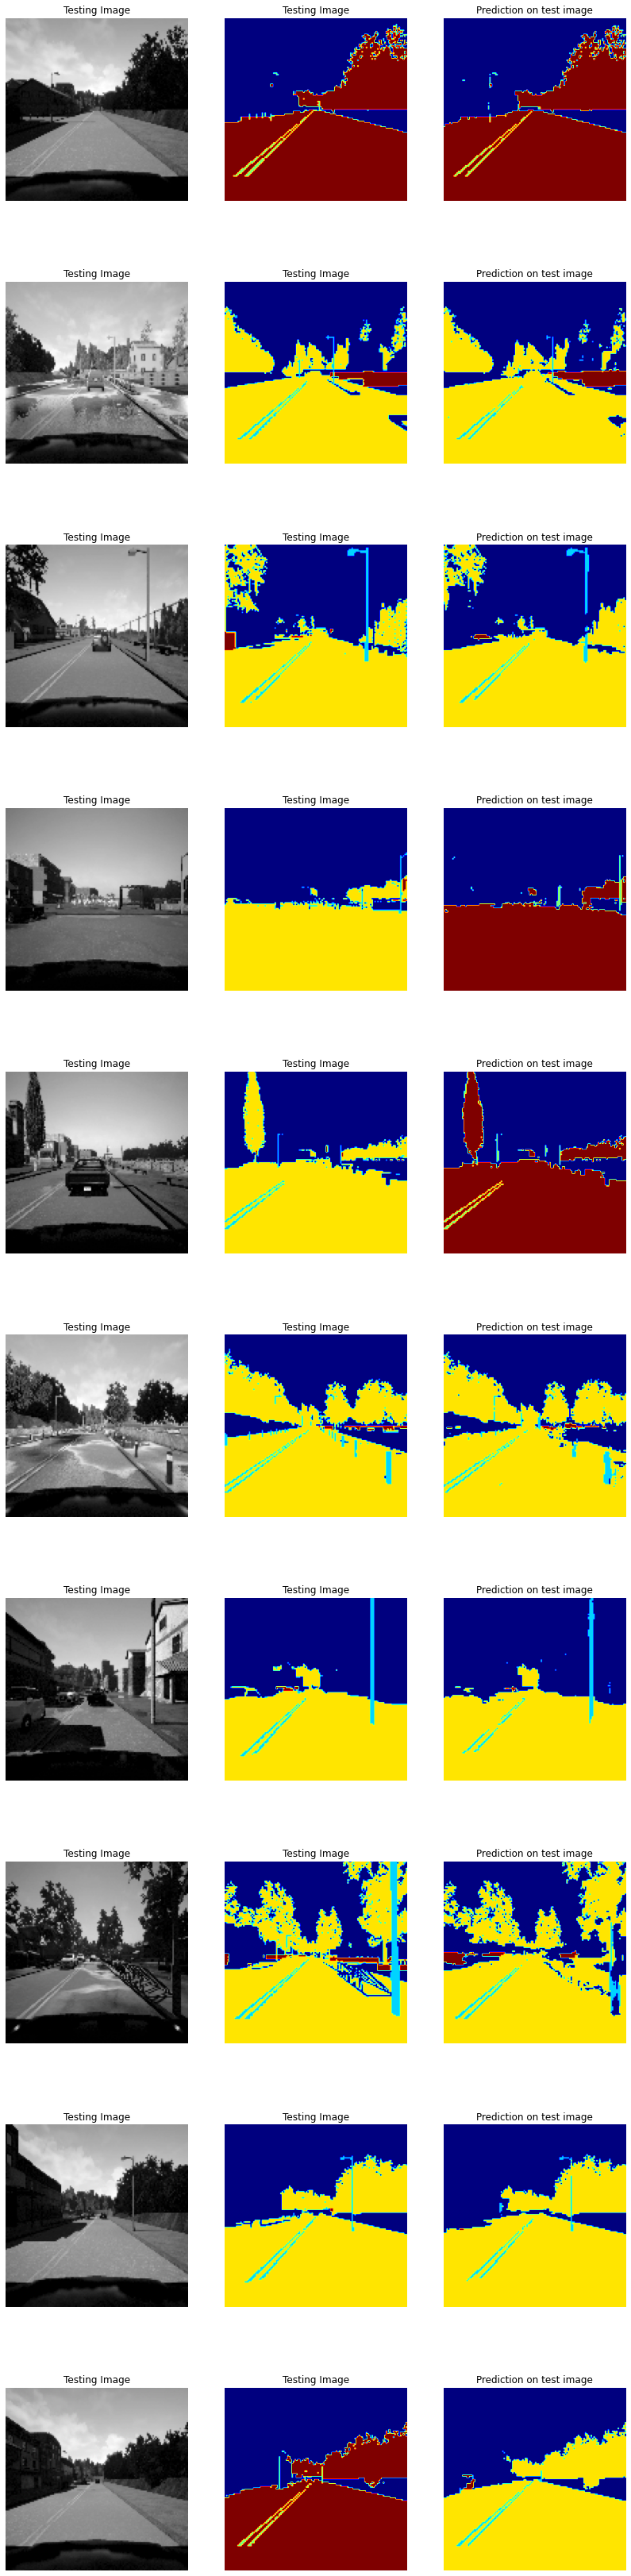

In [76]:
from IPython.core.pylabtools import figsize
import random

num_images = 10
test_img_numbers = np.random.randint(0, len(X_test)-1, num_images)
test_images      = [ X_test[image_number] for image_number in test_img_numbers]
ground_truths    = [ y_test[image_number] for image_number in test_img_numbers]

test_img_norms   = [test_img[:,:,0][:,:,None] for test_img in test_images]

test_img_inputs  = [np.expand_dims(test_img_norm, 0)     for test_img_norm   in test_img_norms]
predictions      = [(model.predict(test_img_input))      for test_img_input  in test_img_inputs]
predicted_imgs   = [np.argmax(prediction, axis=3)[0,:,:] for prediction      in predictions ]

nrows = num_images
ncols = 3

fig, ax = plt.subplots(nrows = nrows , ncols = ncols ,figsize=(14 ,60))

for i in range(nrows):
  ax[i][0].imshow(test_images[i][:,:,0], cmap= 'gray')
  ax[i][0].axis('off')
  ax[i][0].set_title('Testing Image')

  ax[i][1].imshow(ground_truths[i], cmap='jet')
  ax[i][1].axis('off')
  ax[i][1].set_title('Testing Image')

  ax[i][2].imshow(predicted_imgs[i], cmap='jet')
  ax[i][2].axis('off')
  ax[i][2].set_title('Prediction on test image')


In [46]:
#Save the model for future use
best_model_saves = '/content/drive/MyDrive/best models/multiclass_semantic_segmentation/'
os.makedirs(best_model_saves, exist_ok = True)
model.save('/content/drive/MyDrive/best models/multiclass_semantic_segmentation/semantic_segmentation_25epochs.hdf5')

In [ ]:
# checkpoint_path = '/content/drive/MyDrive/best models/multiclass_semantic_segmentation/semantic_segmentation_25epochs.hdf5'
# model.load_weights(checkpoint_path)